```
This notebook sets up and runs a test case for analyzing Kelvin waves
Copyright (C) 2018 - 2022 SINTEF Digital
Copyright (C) 2018 - 2022 Norwegian Meteorological Institute

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

In [1]:
import sys
gpuocean_path = [p[:-4] for p in sys.path if (p.endswith("gpuocean/src") or p.endswith("gpuocean\\src"))][0]
import git
repo = git.Repo(gpuocean_path)
print("GPUOcean code from:", repo.head.object.hexsha, "on branch", repo.active_branch.name)

GPUOcean code from: 711902d818931f354021a809b5b19626dc97837e on branch reduced_gravity


# Boknafjorden

In [2]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
from netCDF4 import Dataset
import datetime, copy
from IPython.display import display

#For plotting
import matplotlib
from matplotlib import pyplot as plt

# plt.rcParams["lines.color"] = "w"
# plt.rcParams["text.color"] = "w"
# plt.rcParams["axes.labelcolor"] = "w"
# plt.rcParams["xtick.color"] = "w"
# plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"

In [3]:
from gpuocean.utils import IPythonMagic, NetCDFInitialization

In [4]:
%cuda_context_handler barotropic_gpu_ctx

In [5]:
%cuda_context_handler baroclinic_gpu_ctx

Path to the test file

In [6]:
source_url = "/lustre/storeB/project/fou/hi/NorFjords160/A03/norfjords_160m_his.nc4_2019110101-2019110200"
source_url = "/sintef/data/NorFjords160/A03/norfjords_160m_his.nc4_2019110101-2019110200"

## Inspecting file structure and content

In [7]:
import xarray as xr
ds = xr.open_dataset(source_url)
ds

<xarray.Dataset>
Dimensions:      (ocean_time: 24, s_rho: 35, s_w: 36, eta_rho: 801, xi_rho: 1161, eta_u: 801, xi_u: 1160, eta_v: 800, xi_v: 1161)
Coordinates:
  * ocean_time   (ocean_time) datetime64[ns] 2019-11-01T01:00:00 ... 2019-11-02
  * s_rho        (s_rho) float64 -0.9857 -0.9571 -0.9286 ... -0.04286 -0.01429
  * s_w          (s_w) float64 -1.0 -0.9714 -0.9429 ... -0.05714 -0.02857 0.0
    lon_rho      (eta_rho, xi_rho) float64 ...
    lat_rho      (eta_rho, xi_rho) float64 ...
    lon_u        (eta_u, xi_u) float64 ...
    lat_u        (eta_u, xi_u) float64 ...
    lon_v        (eta_v, xi_v) float64 ...
    lat_v        (eta_v, xi_v) float64 ...
Dimensions without coordinates: eta_rho, xi_rho, eta_u, xi_u, eta_v, xi_v
Data variables: (12/32)
    Vtransform   int32 ...
    Vstretching  int32 ...
    theta_s      float64 ...
    theta_b      float64 ...
    Tcline       float64 ...
    hc           float64 ...
    ...           ...
    u            (ocean_time, s_rho, eta_u, xi_u) float32 ...
    v            (ocean_time, s_rho, eta_v, xi_v) float32 ...
    temp         (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    salt         (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    AKt          (ocean_time, s_w, eta_rho, xi_rho) float32 ...
    AKs          (ocean_time, s_w, eta_rho, xi_rho) float32 ...
Attributes:
    history:      Created by roms2nc4single.py from ROMS output file
    institution:  Institute of Marine Research
    type:         ROMS/TOMS history file
    title:        ROMS 3.5 - NorFjords
    svn_url:      https://www.myroms.org/svn/omlab/branches/kate
    code_dir:     /cluster/work/users/jonal/NorROMS/ROMS_src/official/ROMS_kate
    CPP_options:  NORFJORDS, ALBEDO, ATM_PRESS, ANA_BSFLUX, ANA_BTFLUX, ANA_S...

In [8]:
from netCDF4 import Dataset
nc = Dataset(source_url)

H_m = np.ma.array(nc["h"][1:-1,1:-1], mask=(1-nc["mask_rho"][1:-1,1:-1]))

## Generating GPUOcean Simulation from Input

In [9]:
dimY, dimX = ds.h.data.shape

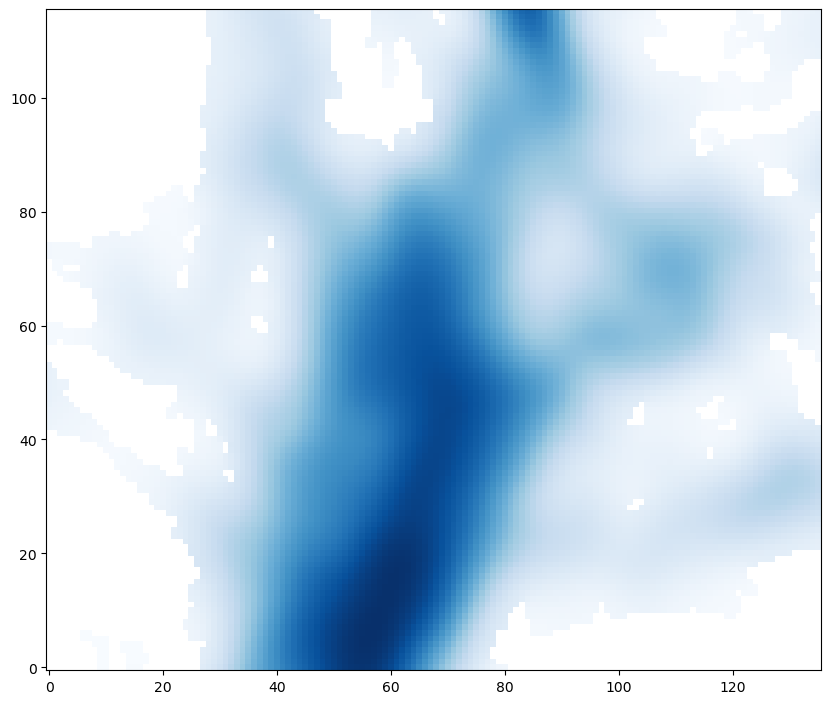

In [10]:
x0, x1, y0, y1 = 685, dimX-360, 335, dimY-330

fig, ax = plt.subplots(figsize=(10,20))
ax.imshow(np.flip(np.ma.array(nc["h"][y0:y1, x0:x1], mask = 1-nc["mask_rho"][y0:y1,x0:x1]), axis=0).T, interpolation="none", cmap="Blues", origin="lower")

In [11]:
nc.variables.keys()

dict_keys(['ocean_time', 'Vtransform', 'Vstretching', 'theta_s', 'theta_b', 'Tcline', 'hc', 's_rho', 's_w', 'Cs_r', 'Cs_w', 'h', 'mask_rho', 'mask_u', 'mask_v', 'angle', 'pm', 'pn', 'lon_rho', 'lat_rho', 'lon_u', 'lat_u', 'lon_v', 'lat_v', 'aice', 'hice', 'snow_thick', 'uice', 'vice', 'zeta', 'ubar', 'vbar', 'Uwind', 'Vwind', 'swrad', 'u', 'v', 'temp', 'salt', 'AKt', 'AKs'])

In [12]:
nx = (x1-x0)-4
ny = (y1-y0)-4

NX = nx+4
NY = ny+4

dx = 160.0
dy = 160.0

Check Mixed-Layer Depth

In [13]:
t=10

In [14]:
mld = NetCDFInitialization.MLD(source_url, 1023, min_mld=1.5, max_mld=35, x0=x0, x1=x1, y0=y0, y1=y1, t=t)
backup_mld = copy.deepcopy(mld)

Note that the stratification is less pronounced than in the Oslofjord, but we still get a usable and shallow MLD

## GPU Ocean Inputs

In [15]:
t_start = t
t_stop =  t_start + 6

timestep_indices = [list(np.arange(t_start, t_start+2))]

In [16]:
ref_dens = 1023.5

In [17]:
_, baroclinic_data_args = NetCDFInitialization.getCombinedInitialConditions(source_url, x0, x1, y0, y1, ref_dens, timestep_indices=timestep_indices, norkyst_data=False, land_value=5.0, download_data=False)

In [18]:
baroclinic_data_args["boundary_conditions"].spongeCells = {'north': 2, 'south': 2, 'east': 2, 'west': 2}

In [19]:
ref_timestep_indices = [list(np.arange(t_start+1, t_start+2))]
_, ref_baroclinic_data_args = NetCDFInitialization.getCombinedInitialConditions(source_url, x0, x1, y0, y1, ref_dens, timestep_indices=ref_timestep_indices, norkyst_data=False, land_value=5.0, download_data=False)

In [20]:
baroclinic_data_args["r"] = 0.0

In [21]:
%cuda_context_handler gpu_ctx

In [22]:
from gpuocean.SWEsimulators import CDKLM16
sim = CDKLM16.CDKLM16(gpu_ctx, **NetCDFInitialization.removeMetadata(baroclinic_data_args),  dt=0.0)
sim.step(3600)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


3600.0

In [23]:
def imshow3(eta, hu, hv, interpolation="None", title=None, figsize=(20,7), interior=False, eta_lim = 20, uv_lim=0.5):
    fig, axs = plt.subplots(1,3, figsize=figsize)
    
    range_eta = eta_lim
    range_huv = uv_lim
    
    if interior:
        eta_im = axs[0].imshow(eta[2:-2,2:-2], interpolation=interpolation, origin='lower', vmin=-range_eta, vmax=range_eta)
    else:
        eta_im = axs[0].imshow(eta, interpolation=interpolation, origin='lower', vmin=-range_eta, vmax=range_eta)
    axs[0].set_title("$h$")
    plt.colorbar(eta_im, ax=axs[0])
    
    if interior:
        hu_im = axs[1].imshow(hu[2:-2,2:-2], interpolation=interpolation, origin='lower', vmin=-range_huv, vmax=range_huv)
    else:
        hu_im = axs[1].imshow(hu, interpolation=interpolation, origin='lower', vmin=-range_huv, vmax=range_huv)
    axs[1].set_title("$u$")
    plt.colorbar(hu_im, ax=axs[1])

    if interior:
        hv_im = axs[2].imshow(hv[2:-2,2:-2], interpolation=interpolation, origin='lower', vmin=-range_huv, vmax=range_huv)
    else:
        hv_im = axs[2].imshow(hv, interpolation=interpolation, origin='lower', vmin=-range_huv, vmax=range_huv)
    axs[2].set_title("$v$")
    plt.colorbar(hv_im, ax=axs[2])

    if title is not None:
        plt.suptitle(title)

In [24]:
init_u = baroclinic_data_args["hu0"]/baroclinic_data_args["eta0"]
init_v = baroclinic_data_args["hv0"]/baroclinic_data_args["eta0"]

ref_u = ref_baroclinic_data_args["hu0"]/ref_baroclinic_data_args["eta0"]
ref_v = ref_baroclinic_data_args["hv0"]/ref_baroclinic_data_args["eta0"]

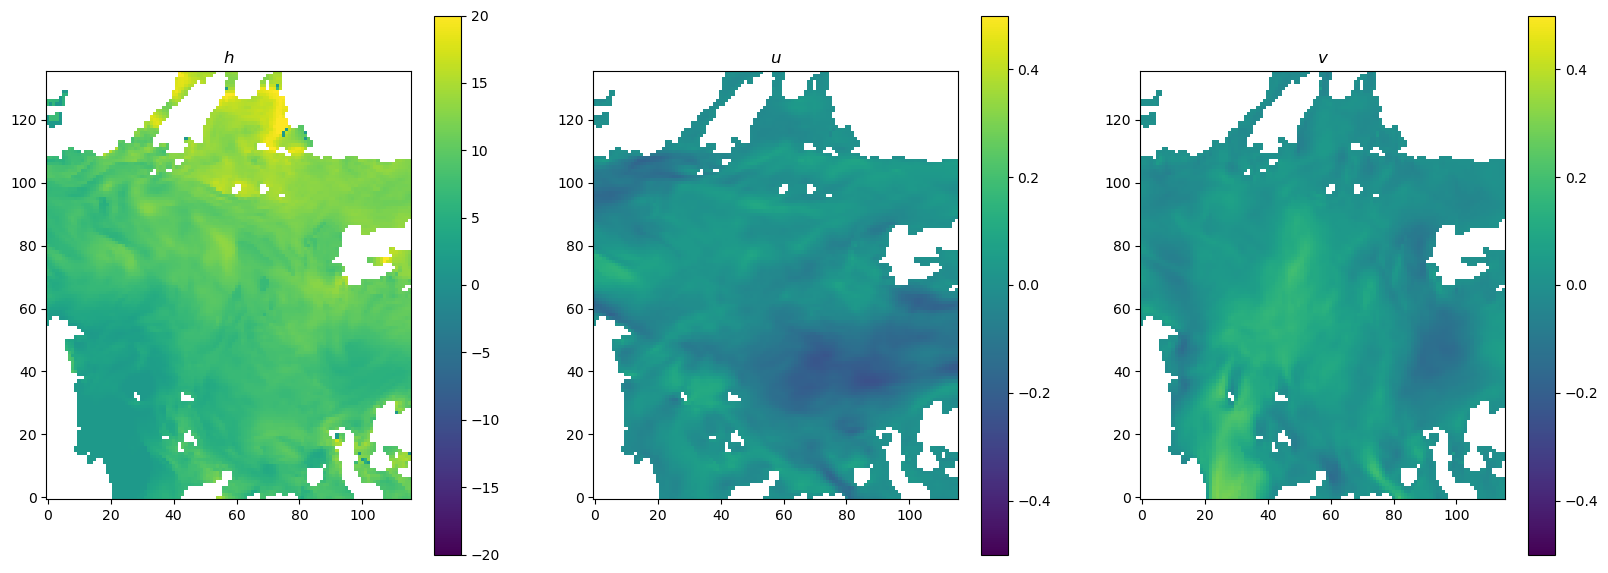

In [25]:
imshow3(baroclinic_data_args["eta0"], init_u, init_v)

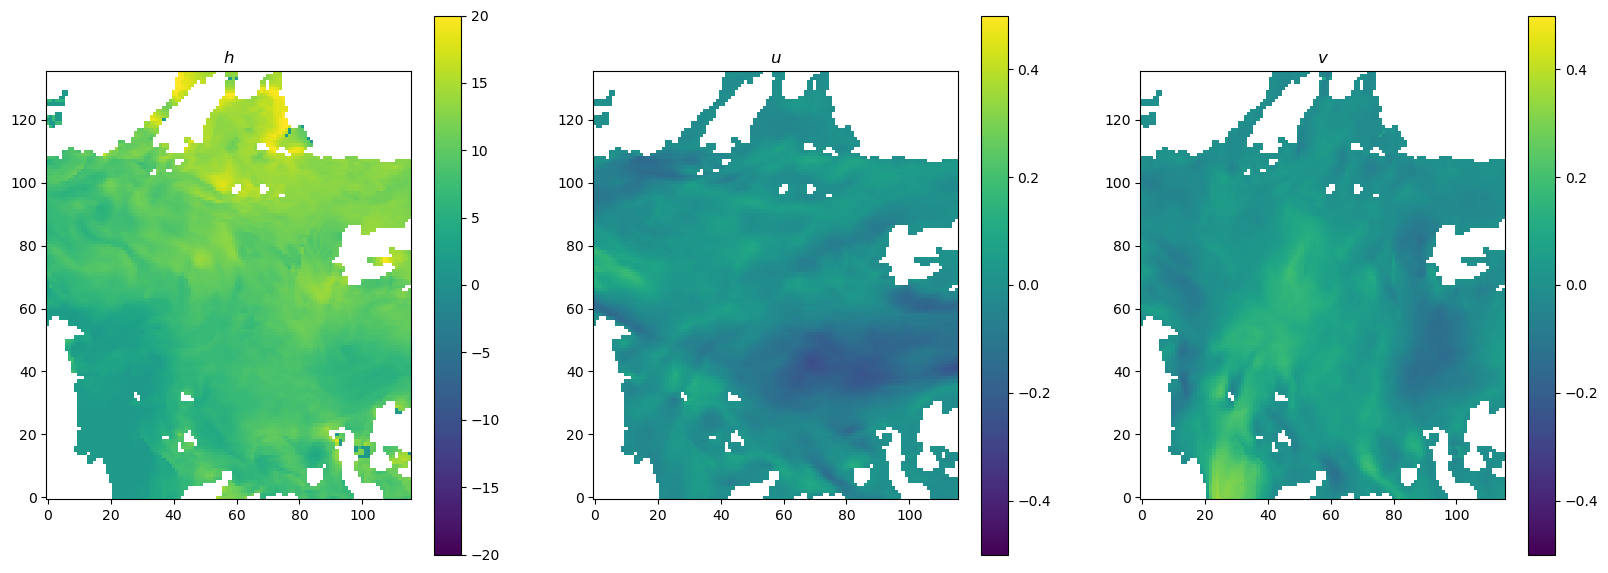

In [26]:
imshow3(ref_baroclinic_data_args["eta0"], ref_u, ref_v)

Text(0.5, 0.98, 'Friction zero, original eta')

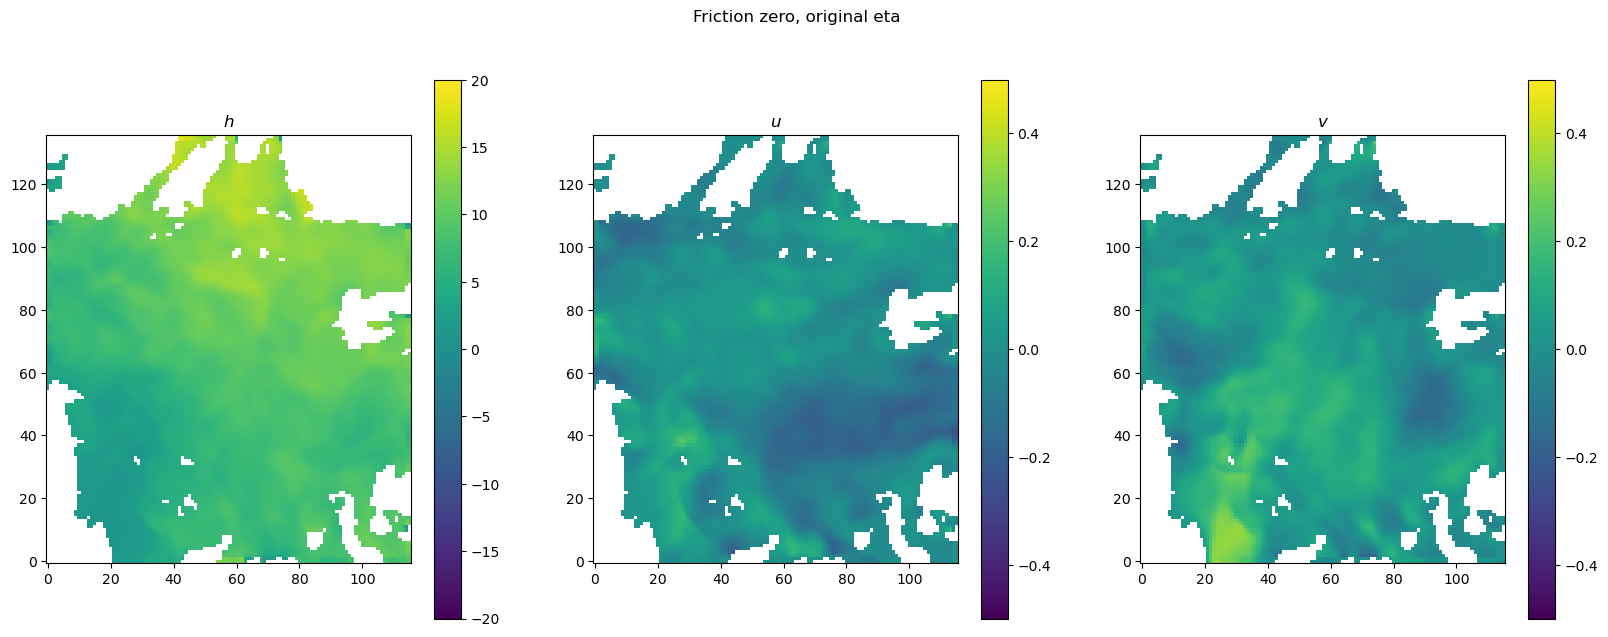

In [27]:
eta, hu, hv = sim.download()

u = hu/eta
v = hv/eta
imshow3(eta, u, v)
plt.suptitle("Friction zero, original eta")

/home/florianb/miniforge3/envs/gpuocean/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


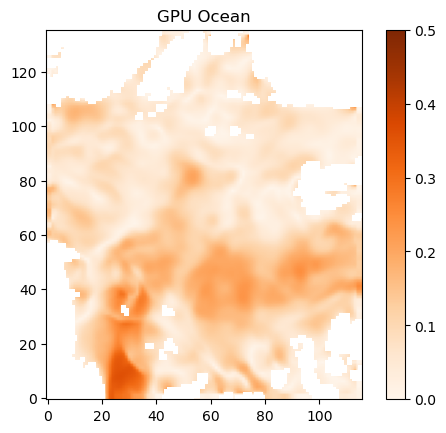

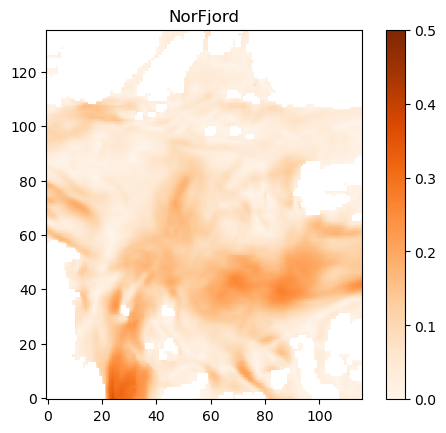

In [29]:
plt.imshow(np.sqrt(u**2+v**2), vmin=0, vmax=0.5, cmap="Oranges")
plt.title("GPU Ocean")
plt.colorbar()
plt.figure()
plt.imshow(np.sqrt(ref_u**2+ref_v**2), vmin=0, vmax=0.5, cmap="Oranges")
plt.title("NorFjord")
plt.colorbar()